In [1]:
import sys
import os
import netsquid as ns
import pydynaa
import pandas
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

from numpy import random
from itertools import combinations

from netsquid.nodes import Node, Connection, Network

from netsquid.protocols import Protocol, NodeProtocol, Signals

from netsquid.util.datacollector import DataCollector

import netsquid.qubits.ketstates as ks

from netsquid.examples.teleportation import example_network_setup
from netsquid.qubits import qubitapi as qapi
from netsquid.qubits.qubitapi import ops
from netsquid.qubits import ketstates, StateSampler, QFormalism, dmutil, sparseutil, ketutil

from netsquid.components import ClassicalChannel, QuantumChannel, QuantumProgram, QuantumProcessor, INSTR_MEASURE
from netsquid.components.qsource import QSource, SourceStatus
from netsquid.components.models import DelayModel, FixedDelayModel, FibreDelayModel, FibreLossModel, DephaseNoiseModel, DepolarNoiseModel
from netsquid.components.qprocessor import QuantumProcessor, PhysicalInstruction
from netsquid.components.instructions import INSTR_ROT_Z, INSTR_INIT, INSTR_EMIT, IMeasureFaulty

import netsquid.components.instructions as instr

import import_ipynb
from NoiseMods import EmissionNoiseModel, CollectiveDephasingNoiseModel
from Instructions import IonTrapMultiQubitRotation, IonTrapMSGate, INSTR_INIT_BELL
from InitPhoton import SendPhoton
from programs import emit_prog

importing Jupyter notebook from NoiseMods.ipynb
importing Jupyter notebook from Instructions.ipynb
importing Jupyter notebook from InitPhoton.ipynb
importing Jupyter notebook from programs.ipynb


In [2]:
def setup(coherence_time, collection_efficiency, fiber_length, attenuation):
    
    ns.set_qstate_formalism(QFormalism.DM)
    
    ion_trap = SendPhoton(num_positions=1, collection_efficiency=collection_efficiency, coherence_time=coherence_time)
    
    ion_trap.add_instruction(instruction=INSTR_INIT_BELL, duration=0)
    q1, q2 = qapi.create_qubits(2)
    ns.qubits.operate(q1, ops.H)
    ns.qubits.operate([q1, q2], ops.CNOT)
    
    loss_model = FibreLossModel(p_loss_length=attenuation, p_loss_init=.1e-2)
    fiber = QuantumChannel(name="fiber", length=fiber_length,
                           models={"quantum_loss_model": loss_model},
                           transmit_empty_items=True)
    
    fiber_loss_model = FibreLossModel(p_loss_length=attenuation, p_loss_init=.1e-2)
    #setting p_loss_init = .01 (99% usually Ba excitation works)
    #double counting for phenomenon in iontrap thru colleciton_efficiency and here thru p_loss_init
    fiber_delay_model = FibreDelayModel(c=3e8/1.5)
    
    fiber = QuantumChannel(name="fiber", length=fiber_length,
                          models={"quantum_loss_model": fiber_loss_model, 
                                 "delay_model": fiber_delay_model},
                          transmit_empty_items=True)
    
    fiber.ports["send"].connect(ion_trap.ports["qout"])
    collection_port = fiber.ports["recv"]

    # collection_port = ion_trap.ports["qout"]

    return ion_trap, collection_port

In [3]:
# in ns
a = 1e3
b = 100e3
c = a
x = np.arange(a, b, c)
xstring = "coherence times"

collection_efficiency = .999
fiber_length = 4e-2
attenuation = 30

previous_fidelity = 0.0
fidelities = []
fidelity_probs = []
expected_fidelity_probs = [] #what should that look like

In [4]:
for i in x:
    
    ion_trap, collection_port = setup(coherence_time = i, collection_efficiency=collection_efficiency,
                                      fiber_length=fiber_length,
                                      attenuation=attenuation)
    num_tries = 50
    
    for _ in range(num_tries):
        #ns.sim_reset()
        ion_trap.execute_program(emit_prog)
        ns.sim_run()
        emitted_message = collection_port.rx_output()
        emitted_qubit = emitted_message.items[0]
        
        qubit_ion = ion_trap.peek([0])[0]
        qubit_photon = emitted_message.items[0]
        print(qubit_ion, qubit_photon)
        
        
        dephase_rate = 1/(i*1e-9)
        #print(dephase_rate)
        ns.qubits.qubitapi.delay_dephase(qubit_ion, dephase_rate, 60e3) #in
        
        if emitted_qubit is not None and emitted_qubit.qstate is not None: 
            fidelity = ns.qubits.fidelity([qubit_ion, qubit_photon], reference_state=ns.b00, squared=False)
            print(fidelity)
            print()
            if fidelity != previous_fidelity:
                fidelity_probs.append(fidelity)
                previous_fidelity = fidelity
                #print(ns.qubits.reduced_dm([qubit_ion,qubit_photon]))
        
    expected_fidelity_prob = (.5*(1 + math.exp(- (60e3+100)/i))) #check onenote for how we found this formula
    expected_fidelity_probs.append(expected_fidelity_prob)

Qubit('QS#1-0') Qubit('QS#2-0')
0.00019955532259537635

Qubit('QS#3-0') None
Qubit('QS#5-0') Qubit('QS#6-0')
0.00019955532259537635

Qubit('QS#7-0') Qubit('QS#8-0')
0.00019955532259537635

Qubit('QS#9-0') None
Qubit('QS#11-0') Qubit('QS#12-0')
0.00019955532259537635

Qubit('QS#13-0') None
Qubit('QS#15-0') Qubit('QS#16-0')
0.00019955532259537635

Qubit('QS#17-0') Qubit('QS#18-0')
0.00019955532259537635

Qubit('QS#19-0') Qubit('QS#20-0')
0.00019955532259537635

Qubit('QS#21-0') Qubit('QS#22-0')
0.00019955532259537635

Qubit('QS#23-0') Qubit('QS#24-0')
0.00019955532259537635

Qubit('QS#25-0') Qubit('QS#26-0')
0.00019955532259537635

Qubit('QS#27-0') Qubit('QS#28-0')
0.00019955532259537635

Qubit('QS#29-0') Qubit('QS#30-0')
0.00019955532259537635

Qubit('QS#31-0') Qubit('QS#32-0')
0.00019955532259537635

Qubit('QS#33-0') Qubit('QS#34-0')
0.00019955532259537635

Qubit('QS#35-0') Qubit('QS#36-0')
0.00019955532259537635

Qubit('QS#37-0') Qubit('QS#38-0')
0.00019955532259537635

Qubit('QS#39-0

Qubit('QS#360-0') Qubit('QS#361-0')
0.0005531880402126448

Qubit('QS#362-0') None
Qubit('QS#364-0') None
Qubit('QS#366-0') None
Qubit('QS#368-0') Qubit('QS#369-0')
0.0005531880402126448

Qubit('QS#370-0') Qubit('QS#371-0')
0.0005531880402126448

Qubit('QS#372-0') None
Qubit('QS#374-0') Qubit('QS#375-0')
0.0005531880402126448

Qubit('QS#376-0') Qubit('QS#377-0')
0.0005531880402126448

Qubit('QS#378-0') Qubit('QS#379-0')
0.0005531880402126448

Qubit('QS#380-0') Qubit('QS#381-0')
0.0005531880402126448

Qubit('QS#382-0') None
Qubit('QS#384-0') Qubit('QS#385-0')
0.0005531880402126448

Qubit('QS#386-0') Qubit('QS#387-0')
0.0005531880402126448

Qubit('QS#388-0') Qubit('QS#389-0')
0.0005531880402126448

Qubit('QS#390-0') Qubit('QS#391-0')
0.0005531880402126448

Qubit('QS#392-0') Qubit('QS#393-0')
0.0005531880402126448

Qubit('QS#394-0') Qubit('QS#395-0')
0.0005531880402126448

Qubit('QS#396-0') None
Qubit('QS#398-0') Qubit('QS#399-0')
0.0005531880402126448

Qubit('QS#400-0') Qubit('QS#401-0')


Qubit('QS#736-0') Qubit('QS#737-0')
0.02351777335013972

Qubit('QS#738-0') Qubit('QS#739-0')
0.02351777335013972

Qubit('QS#740-0') Qubit('QS#741-0')
0.02351777335013972

Qubit('QS#742-0') Qubit('QS#743-0')
0.02351777335013972

Qubit('QS#744-0') Qubit('QS#745-0')
0.02351777335013972

Qubit('QS#746-0') Qubit('QS#747-0')
0.02351777335013972

Qubit('QS#748-0') Qubit('QS#749-0')
0.02351777335013972

Qubit('QS#750-0') Qubit('QS#751-0')
0.02351777335013972

Qubit('QS#752-0') Qubit('QS#753-0')
0.02351777335013972

Qubit('QS#754-0') Qubit('QS#755-0')
0.02351777335013972

Qubit('QS#756-0') Qubit('QS#757-0')
0.02351777335013972

Qubit('QS#758-0') Qubit('QS#759-0')
0.02351777335013972

Qubit('QS#760-0') Qubit('QS#761-0')
0.02351777335013972

Qubit('QS#762-0') None
Qubit('QS#764-0') None
Qubit('QS#766-0') Qubit('QS#767-0')
0.02351777335013972

Qubit('QS#768-0') Qubit('QS#769-0')
0.02351777335013972

Qubit('QS#770-0') Qubit('QS#771-0')
0.02351777335013972

Qubit('QS#772-0') Qubit('QS#773-0')
0.0235

Qubit('QS#1089-0') None
Qubit('QS#1091-0') Qubit('QS#1092-0')
0.06539741027666003

Qubit('QS#1093-0') Qubit('QS#1094-0')
0.06539741027666003

Qubit('QS#1095-0') None
Qubit('QS#1097-0') Qubit('QS#1098-0')
0.06539741027666003

Qubit('QS#1099-0') Qubit('QS#1100-0')
0.06539741027666003

Qubit('QS#1101-0') Qubit('QS#1102-0')
0.06539741027666003

Qubit('QS#1103-0') Qubit('QS#1104-0')
0.06539741027666003

Qubit('QS#1105-0') Qubit('QS#1106-0')
0.06539741027666003

Qubit('QS#1107-0') Qubit('QS#1108-0')
0.06539741027666003

Qubit('QS#1109-0') Qubit('QS#1110-0')
0.06539741027666003

Qubit('QS#1112-0') Qubit('QS#1113-0')
0.08208500099393638

Qubit('QS#1114-0') Qubit('QS#1115-0')
0.08208500099393638

Qubit('QS#1116-0') Qubit('QS#1117-0')
0.08208500099393638

Qubit('QS#1118-0') Qubit('QS#1119-0')
0.08208500099393638

Qubit('QS#1120-0') Qubit('QS#1121-0')
0.08208500099393638

Qubit('QS#1122-0') Qubit('QS#1123-0')
0.08208500099393638

Qubit('QS#1124-0') None
Qubit('QS#1126-0') Qubit('QS#1127-0')
0.082

Qubit('QS#1467-0') Qubit('QS#1468-0')
0.1353352846610743

Qubit('QS#1469-0') Qubit('QS#1470-0')
0.1353352846610743

Qubit('QS#1471-0') None
Qubit('QS#1473-0') Qubit('QS#1474-0')
0.1353352846610743

Qubit('QS#1475-0') None
Qubit('QS#1477-0') Qubit('QS#1478-0')
0.1353352846610743

Qubit('QS#1479-0') None
Qubit('QS#1481-0') Qubit('QS#1482-0')
0.1353352846610743

Qubit('QS#1483-0') Qubit('QS#1484-0')
0.1353352846610743

Qubit('QS#1485-0') Qubit('QS#1486-0')
0.1353352846610743

Qubit('QS#1487-0') None
Qubit('QS#1489-0') None
Qubit('QS#1491-0') Qubit('QS#1492-0')
0.1353352846610743

Qubit('QS#1493-0') Qubit('QS#1494-0')
0.1353352846610743

Qubit('QS#1495-0') Qubit('QS#1496-0')
0.1353352846610743

Qubit('QS#1497-0') None
Qubit('QS#1499-0') Qubit('QS#1500-0')
0.1353352846610743

Qubit('QS#1501-0') Qubit('QS#1502-0')
0.1353352846610743

Qubit('QS#1503-0') Qubit('QS#1504-0')
0.1353352846610743

Qubit('QS#1505-0') Qubit('QS#1506-0')
0.1353352846610743

Qubit('QS#1507-0') Qubit('QS#1508-0')
0.1353

Qubit('QS#1837-0') None
Qubit('QS#1839-0') Qubit('QS#1840-0')
0.20619202831694183

Qubit('QS#1841-0') Qubit('QS#1842-0')
0.20619202831694183

Qubit('QS#1843-0') None
Qubit('QS#1845-0') Qubit('QS#1846-0')
0.20619202831694183

Qubit('QS#1847-0') Qubit('QS#1848-0')
0.20619202831694183

Qubit('QS#1849-0') Qubit('QS#1850-0')
0.20619202831694183

Qubit('QS#1851-0') Qubit('QS#1852-0')
0.20619202831694183

Qubit('QS#1853-0') None
Qubit('QS#1855-0') Qubit('QS#1856-0')
0.20619202831694183

Qubit('QS#1857-0') Qubit('QS#1858-0')
0.20619202831694183

Qubit('QS#1859-0') Qubit('QS#1860-0')
0.20619202831694183

Qubit('QS#1861-0') Qubit('QS#1862-0')
0.20619202831694183

Qubit('QS#1863-0') Qubit('QS#1864-0')
0.20619202831694183

Qubit('QS#1865-0') Qubit('QS#1866-0')
0.20619202831694183

Qubit('QS#1867-0') Qubit('QS#1868-0')
0.20619202831694183

Qubit('QS#1869-0') Qubit('QS#1870-0')
0.20619202831694183

Qubit('QS#1871-0') Qubit('QS#1872-0')
0.20619202831694183

Qubit('QS#1873-0') Qubit('QS#1874-0')
0.206

Qubit('QS#2208-0') Qubit('QS#2209-0')
0.255729159940792

Qubit('QS#2210-0') None
Qubit('QS#2212-0') Qubit('QS#2213-0')
0.255729159940792

Qubit('QS#2214-0') Qubit('QS#2215-0')
0.255729159940792

Qubit('QS#2216-0') Qubit('QS#2217-0')
0.255729159940792

Qubit('QS#2218-0') Qubit('QS#2219-0')
0.255729159940792

Qubit('QS#2220-0') Qubit('QS#2221-0')
0.255729159940792

Qubit('QS#2223-0') Qubit('QS#2224-0')
0.2713494447016076

Qubit('QS#2225-0') None
Qubit('QS#2227-0') None
Qubit('QS#2229-0') None
Qubit('QS#2231-0') Qubit('QS#2232-0')
0.2713494447016076

Qubit('QS#2233-0') None
Qubit('QS#2235-0') Qubit('QS#2236-0')
0.2713494447016076

Qubit('QS#2237-0') Qubit('QS#2238-0')
0.2713494447016076

Qubit('QS#2239-0') Qubit('QS#2240-0')
0.2713494447016076

Qubit('QS#2241-0') Qubit('QS#2242-0')
0.2713494447016076

Qubit('QS#2243-0') None
Qubit('QS#2245-0') Qubit('QS#2246-0')
0.2713494447016076

Qubit('QS#2247-0') Qubit('QS#2248-0')
0.2713494447016076

Qubit('QS#2249-0') Qubit('QS#2250-0')
0.2713494447

Qubit('QS#2582-0') Qubit('QS#2583-0')
0.3154212746463961

Qubit('QS#2584-0') Qubit('QS#2585-0')
0.3154212746463961

Qubit('QS#2586-0') Qubit('QS#2587-0')
0.3154212746463961

Qubit('QS#2588-0') Qubit('QS#2589-0')
0.3154212746463961

Qubit('QS#2590-0') Qubit('QS#2591-0')
0.3154212746463961

Qubit('QS#2592-0') Qubit('QS#2593-0')
0.3154212746463961

Qubit('QS#2594-0') Qubit('QS#2595-0')
0.3154212746463961

Qubit('QS#2596-0') None
Qubit('QS#2598-0') Qubit('QS#2599-0')
0.3154212746463961

Qubit('QS#2600-0') None
Qubit('QS#2602-0') Qubit('QS#2603-0')
0.3154212746463961

Qubit('QS#2604-0') None
Qubit('QS#2606-0') Qubit('QS#2607-0')
0.3154212746463961

Qubit('QS#2608-0') None
Qubit('QS#2610-0') Qubit('QS#2611-0')
0.3154212746463961

Qubit('QS#2612-0') Qubit('QS#2613-0')
0.3154212746463961

Qubit('QS#2614-0') Qubit('QS#2615-0')
0.3154212746463961

Qubit('QS#2616-0') Qubit('QS#2617-0')
0.3154212746463961

Qubit('QS#2618-0') Qubit('QS#2619-0')
0.3154212746463961

Qubit('QS#2620-0') None
Qubit('QS#

Qubit('QS#2956-0') Qubit('QS#2957-0')
0.36787944117453436

Qubit('QS#2958-0') Qubit('QS#2959-0')
0.36787944117453436

Qubit('QS#2960-0') Qubit('QS#2961-0')
0.36787944117453436

Qubit('QS#2962-0') Qubit('QS#2963-0')
0.36787944117453436

Qubit('QS#2964-0') Qubit('QS#2965-0')
0.36787944117453436

Qubit('QS#2966-0') Qubit('QS#2967-0')
0.36787944117453436

Qubit('QS#2968-0') Qubit('QS#2969-0')
0.36787944117453436

Qubit('QS#2970-0') Qubit('QS#2971-0')
0.36787944117453436

Qubit('QS#2972-0') Qubit('QS#2973-0')
0.36787944117453436

Qubit('QS#2974-0') Qubit('QS#2975-0')
0.36787944117453436

Qubit('QS#2976-0') Qubit('QS#2977-0')
0.36787944117453436

Qubit('QS#2978-0') Qubit('QS#2979-0')
0.36787944117453436

Qubit('QS#2980-0') Qubit('QS#2981-0')
0.36787944117453436

Qubit('QS#2982-0') Qubit('QS#2983-0')
0.36787944117453436

Qubit('QS#2984-0') Qubit('QS#2985-0')
0.36787944117453436

Qubit('QS#2986-0') Qubit('QS#2987-0')
0.36787944117453436

Qubit('QS#2988-0') Qubit('QS#2989-0')
0.3678794411745343

Qubit('QS#3321-0') Qubit('QS#3322-0')
0.40289032168602795

Qubit('QS#3323-0') Qubit('QS#3324-0')
0.40289032168602795

Qubit('QS#3325-0') Qubit('QS#3326-0')
0.40289032168602795

Qubit('QS#3327-0') Qubit('QS#3328-0')
0.40289032168602795

Qubit('QS#3329-0') None
Qubit('QS#3331-0') Qubit('QS#3332-0')
0.40289032168602795

Qubit('QS#3334-0') Qubit('QS#3335-0')
0.41380809918817735

Qubit('QS#3336-0') None
Qubit('QS#3338-0') Qubit('QS#3339-0')
0.41380809918817735

Qubit('QS#3340-0') Qubit('QS#3341-0')
0.41380809918817735

Qubit('QS#3342-0') Qubit('QS#3343-0')
0.41380809918817735

Qubit('QS#3344-0') Qubit('QS#3345-0')
0.41380809918817735

Qubit('QS#3346-0') Qubit('QS#3347-0')
0.41380809918817735

Qubit('QS#3348-0') Qubit('QS#3349-0')
0.41380809918817735

Qubit('QS#3350-0') Qubit('QS#3351-0')
0.41380809918817735

Qubit('QS#3352-0') Qubit('QS#3353-0')
0.41380809918817735

Qubit('QS#3354-0') Qubit('QS#3355-0')
0.41380809918817735

Qubit('QS#3356-0') Qubit('QS#3357-0')
0.41380809918817735

Qubit('Q

Qubit('QS#3699-0') Qubit('QS#3700-0')
0.4444975166831299

Qubit('QS#3701-0') None
Qubit('QS#3703-0') Qubit('QS#3704-0')
0.4444975166831299

Qubit('QS#3705-0') Qubit('QS#3706-0')
0.4444975166831299

Qubit('QS#3707-0') Qubit('QS#3708-0')
0.4444975166831299

Qubit('QS#3709-0') Qubit('QS#3710-0')
0.4444975166831299

Qubit('QS#3711-0') None
Qubit('QS#3713-0') None
Qubit('QS#3715-0') Qubit('QS#3716-0')
0.4444975166831299

Qubit('QS#3717-0') Qubit('QS#3718-0')
0.4444975166831299

Qubit('QS#3719-0') Qubit('QS#3720-0')
0.4444975166831299

Qubit('QS#3721-0') Qubit('QS#3722-0')
0.4444975166831299

Qubit('QS#3723-0') Qubit('QS#3724-0')
0.4444975166831299

Qubit('QS#3725-0') Qubit('QS#3726-0')
0.4444975166831299

Qubit('QS#3727-0') Qubit('QS#3728-0')
0.4444975166831299

Qubit('QS#3729-0') Qubit('QS#3730-0')
0.4444975166831299

Qubit('QS#3731-0') Qubit('QS#3732-0')
0.4444975166831299

Qubit('QS#3733-0') Qubit('QS#3734-0')
0.4444975166831299

Qubit('QS#3735-0') None
Qubit('QS#3738-0') None
Qubit('QS#

Qubit('QS#4063-0') Qubit('QS#4064-0')
0.48108692061738306

Qubit('QS#4065-0') Qubit('QS#4066-0')
0.48108692061738306

Qubit('QS#4067-0') Qubit('QS#4068-0')
0.48108692061738306

Qubit('QS#4069-0') Qubit('QS#4070-0')
0.48108692061738306

Qubit('QS#4071-0') Qubit('QS#4072-0')
0.48108692061738306

Qubit('QS#4073-0') Qubit('QS#4074-0')
0.48108692061738306

Qubit('QS#4075-0') None
Qubit('QS#4077-0') Qubit('QS#4078-0')
0.48108692061738306

Qubit('QS#4079-0') Qubit('QS#4080-0')
0.48108692061738306

Qubit('QS#4081-0') Qubit('QS#4082-0')
0.48108692061738306

Qubit('QS#4083-0') Qubit('QS#4084-0')
0.48108692061738306

Qubit('QS#4085-0') Qubit('QS#4086-0')
0.48108692061738306

Qubit('QS#4087-0') Qubit('QS#4088-0')
0.48108692061738306

Qubit('QS#4089-0') Qubit('QS#4090-0')
0.48108692061738306

Qubit('QS#4091-0') Qubit('QS#4092-0')
0.48108692061738306

Qubit('QS#4093-0') Qubit('QS#4094-0')
0.48108692061738306

Qubit('QS#4095-0') Qubit('QS#4096-0')
0.48108692061738306

Qubit('QS#4097-0') None
Qubit('Q

Qubit('QS#4404-0') None
Qubit('QS#4406-0') None
Qubit('QS#4408-0') Qubit('QS#4409-0')
0.5056967074456036

Qubit('QS#4410-0') Qubit('QS#4411-0')
0.5056967074456036

Qubit('QS#4412-0') None
Qubit('QS#4414-0') Qubit('QS#4415-0')
0.5056967074456036

Qubit('QS#4416-0') Qubit('QS#4417-0')
0.5056967074456036

Qubit('QS#4418-0') Qubit('QS#4419-0')
0.5056967074456036

Qubit('QS#4420-0') Qubit('QS#4421-0')
0.5056967074456036

Qubit('QS#4422-0') Qubit('QS#4423-0')
0.5056967074456036

Qubit('QS#4424-0') None
Qubit('QS#4426-0') None
Qubit('QS#4428-0') None
Qubit('QS#4430-0') Qubit('QS#4431-0')
0.5056967074456036

Qubit('QS#4432-0') Qubit('QS#4433-0')
0.5056967074456036

Qubit('QS#4434-0') None
Qubit('QS#4436-0') Qubit('QS#4437-0')
0.5056967074456036

Qubit('QS#4438-0') Qubit('QS#4439-0')
0.5056967074456036

Qubit('QS#4440-0') Qubit('QS#4441-0')
0.5056967074456036

Qubit('QS#4442-0') Qubit('QS#4443-0')
0.5056967074456036

Qubit('QS#4445-0') Qubit('QS#4446-0')
0.5134171190529936

Qubit('QS#4447-0') Q

Qubit('QS#4770-0') Qubit('QS#4771-0')
0.5352614285196456

Qubit('QS#4772-0') Qubit('QS#4773-0')
0.5352614285196456

Qubit('QS#4774-0') Qubit('QS#4775-0')
0.5352614285196456

Qubit('QS#4776-0') Qubit('QS#4777-0')
0.5352614285196456

Qubit('QS#4778-0') Qubit('QS#4779-0')
0.5352614285196456

Qubit('QS#4780-0') None
Qubit('QS#4782-0') Qubit('QS#4783-0')
0.5352614285196456

Qubit('QS#4784-0') Qubit('QS#4785-0')
0.5352614285196456

Qubit('QS#4786-0') None
Qubit('QS#4788-0') Qubit('QS#4789-0')
0.5352614285196456

Qubit('QS#4790-0') None
Qubit('QS#4792-0') None
Qubit('QS#4794-0') None
Qubit('QS#4796-0') Qubit('QS#4797-0')
0.5352614285196456

Qubit('QS#4798-0') Qubit('QS#4799-0')
0.5352614285196456

Qubit('QS#4800-0') Qubit('QS#4801-0')
0.5352614285196456

Qubit('QS#4802-0') None
Qubit('QS#4804-0') Qubit('QS#4805-0')
0.5352614285196456

Qubit('QS#4806-0') Qubit('QS#4807-0')
0.5352614285196456

Qubit('QS#4808-0') Qubit('QS#4809-0')
0.5352614285196456

Qubit('QS#4810-0') Qubit('QS#4811-0')
0.5352

Qubit('QS#5133-0') Qubit('QS#5134-0')
0.5553063730037908

Qubit('QS#5135-0') Qubit('QS#5136-0')
0.5553063730037908

Qubit('QS#5137-0') Qubit('QS#5138-0')
0.5553063730037908

Qubit('QS#5139-0') Qubit('QS#5140-0')
0.5553063730037908

Qubit('QS#5141-0') Qubit('QS#5142-0')
0.5553063730037908

Qubit('QS#5143-0') None
Qubit('QS#5145-0') Qubit('QS#5146-0')
0.5553063730037908

Qubit('QS#5147-0') Qubit('QS#5148-0')
0.5553063730037908

Qubit('QS#5149-0') None
Qubit('QS#5152-0') Qubit('QS#5153-0')
0.561623783897219

Qubit('QS#5154-0') Qubit('QS#5155-0')
0.561623783897219

Qubit('QS#5156-0') Qubit('QS#5157-0')
0.561623783897219

Qubit('QS#5158-0') Qubit('QS#5159-0')
0.561623783897219

Qubit('QS#5160-0') None
Qubit('QS#5162-0') Qubit('QS#5163-0')
0.561623783897219

Qubit('QS#5164-0') Qubit('QS#5165-0')
0.561623783897219

Qubit('QS#5166-0') None
Qubit('QS#5168-0') Qubit('QS#5169-0')
0.561623783897219

Qubit('QS#5170-0') Qubit('QS#5171-0')
0.561623783897219

Qubit('QS#5172-0') Qubit('QS#5173-0')
0.56

Qubit('QS#5497-0') None
Qubit('QS#5499-0') Qubit('QS#5500-0')
0.5795782787882893

Qubit('QS#5501-0') None
Qubit('QS#5503-0') Qubit('QS#5504-0')
0.5795782787882893

Qubit('QS#5505-0') Qubit('QS#5506-0')
0.5795782787882893

Qubit('QS#5507-0') Qubit('QS#5508-0')
0.5795782787882893

Qubit('QS#5509-0') Qubit('QS#5510-0')
0.5795782787882893

Qubit('QS#5511-0') None
Qubit('QS#5513-0') Qubit('QS#5514-0')
0.5795782787882893

Qubit('QS#5515-0') Qubit('QS#5516-0')
0.5795782787882893

Qubit('QS#5517-0') None
Qubit('QS#5519-0') Qubit('QS#5520-0')
0.5795782787882893

Qubit('QS#5521-0') Qubit('QS#5522-0')
0.5795782787882893

Qubit('QS#5523-0') Qubit('QS#5524-0')
0.5795782787882893

Qubit('QS#5525-0') Qubit('QS#5526-0')
0.5795782787882893

Qubit('QS#5527-0') Qubit('QS#5528-0')
0.5795782787882893

Qubit('QS#5529-0') Qubit('QS#5530-0')
0.5795782787882893

Qubit('QS#5531-0') None
Qubit('QS#5533-0') Qubit('QS#5534-0')
0.5795782787882893

Qubit('QS#5535-0') Qubit('QS#5536-0')
0.5795782787882893

Qubit('QS#

Qubit('QS#5840-0') Qubit('QS#5841-0')
0.5961628688865056

Qubit('QS#5842-0') Qubit('QS#5843-0')
0.5961628688865056

Qubit('QS#5844-0') Qubit('QS#5845-0')
0.5961628688865056

Qubit('QS#5846-0') Qubit('QS#5847-0')
0.5961628688865056

Qubit('QS#5848-0') None
Qubit('QS#5850-0') Qubit('QS#5851-0')
0.5961628688865056

Qubit('QS#5852-0') None
Qubit('QS#5854-0') Qubit('QS#5855-0')
0.5961628688865056

Qubit('QS#5856-0') Qubit('QS#5857-0')
0.5961628688865056

Qubit('QS#5859-0') Qubit('QS#5860-0')
0.6014122880256418

Qubit('QS#5861-0') Qubit('QS#5862-0')
0.6014122880256418

Qubit('QS#5863-0') Qubit('QS#5864-0')
0.6014122880256418

Qubit('QS#5865-0') None
Qubit('QS#5867-0') None
Qubit('QS#5869-0') Qubit('QS#5870-0')
0.6014122880256418

Qubit('QS#5871-0') Qubit('QS#5872-0')
0.6014122880256418

Qubit('QS#5873-0') Qubit('QS#5874-0')
0.6014122880256418

Qubit('QS#5875-0') None
Qubit('QS#5877-0') Qubit('QS#5878-0')
0.6014122880256418

Qubit('QS#5879-0') Qubit('QS#5880-0')
0.6014122880256418

Qubit('QS#

Qubit('QS#6190-0') Qubit('QS#6191-0')
0.6163927313280656

Qubit('QS#6192-0') Qubit('QS#6193-0')
0.6163927313280656

Qubit('QS#6194-0') Qubit('QS#6195-0')
0.6163927313280656

Qubit('QS#6196-0') Qubit('QS#6197-0')
0.6163927313280656

Qubit('QS#6198-0') None
Qubit('QS#6200-0') Qubit('QS#6201-0')
0.6163927313280656

Qubit('QS#6202-0') None
Qubit('QS#6204-0') Qubit('QS#6205-0')
0.6163927313280656

Qubit('QS#6206-0') Qubit('QS#6207-0')
0.6163927313280656

Qubit('QS#6208-0') None
Qubit('QS#6210-0') Qubit('QS#6211-0')
0.6163927313280656

Qubit('QS#6212-0') Qubit('QS#6213-0')
0.6163927313280656

Qubit('QS#6214-0') Qubit('QS#6215-0')
0.6163927313280656

Qubit('QS#6216-0') Qubit('QS#6217-0')
0.6163927313280656

Qubit('QS#6218-0') Qubit('QS#6219-0')
0.6163927313280656

Qubit('QS#6220-0') Qubit('QS#6221-0')
0.6163927313280656

Qubit('QS#6222-0') Qubit('QS#6223-0')
0.6163927313280656

Qubit('QS#6224-0') Qubit('QS#6225-0')
0.6163927313280656

Qubit('QS#6226-0') Qubit('QS#6227-0')
0.6163927313280656



Qubit('QS#6535-0') Qubit('QS#6536-0')
0.6303131866009122

Qubit('QS#6537-0') None
Qubit('QS#6539-0') Qubit('QS#6540-0')
0.6303131866009122

Qubit('QS#6541-0') None
Qubit('QS#6543-0') Qubit('QS#6544-0')
0.6303131866009122

Qubit('QS#6545-0') Qubit('QS#6546-0')
0.6303131866009122

Qubit('QS#6547-0') None
Qubit('QS#6549-0') Qubit('QS#6550-0')
0.6303131866009122

Qubit('QS#6551-0') Qubit('QS#6552-0')
0.6303131866009122

Qubit('QS#6553-0') Qubit('QS#6554-0')
0.6303131866009122

Qubit('QS#6555-0') Qubit('QS#6556-0')
0.6303131866009122

Qubit('QS#6557-0') Qubit('QS#6558-0')
0.6303131866009122

Qubit('QS#6559-0') None
Qubit('QS#6561-0') Qubit('QS#6562-0')
0.6303131866009122

Qubit('QS#6563-0') Qubit('QS#6564-0')
0.6303131866009122

Qubit('QS#6566-0') Qubit('QS#6567-0')
0.6347364189413726

Qubit('QS#6568-0') Qubit('QS#6569-0')
0.6347364189413726

Qubit('QS#6570-0') Qubit('QS#6571-0')
0.6347364189413726

Qubit('QS#6572-0') Qubit('QS#6573-0')
0.6347364189413726

Qubit('QS#6574-0') Qubit('QS#6575-

Qubit('QS#6885-0') Qubit('QS#6886-0')
0.647405392083941

Qubit('QS#6887-0') Qubit('QS#6888-0')
0.647405392083941

Qubit('QS#6889-0') Qubit('QS#6890-0')
0.647405392083941

Qubit('QS#6891-0') Qubit('QS#6892-0')
0.647405392083941

Qubit('QS#6893-0') Qubit('QS#6894-0')
0.647405392083941

Qubit('QS#6895-0') Qubit('QS#6896-0')
0.647405392083941

Qubit('QS#6897-0') Qubit('QS#6898-0')
0.647405392083941

Qubit('QS#6899-0') Qubit('QS#6900-0')
0.647405392083941

Qubit('QS#6901-0') Qubit('QS#6902-0')
0.647405392083941

Qubit('QS#6903-0') Qubit('QS#6904-0')
0.647405392083941

Qubit('QS#6905-0') Qubit('QS#6906-0')
0.647405392083941

Qubit('QS#6907-0') Qubit('QS#6908-0')
0.647405392083941

Qubit('QS#6909-0') Qubit('QS#6910-0')
0.647405392083941

Qubit('QS#6911-0') None
Qubit('QS#6913-0') None
Qubit('QS#6915-0') Qubit('QS#6916-0')
0.647405392083941

Qubit('QS#6917-0') Qubit('QS#6918-0')
0.647405392083941

Qubit('QS#6919-0') Qubit('QS#6920-0')
0.647405392083941

Qubit('QS#6921-0') Qubit('QS#6922-0')
0.

Qubit('QS#7224-0') None
Qubit('QS#7226-0') None
Qubit('QS#7228-0') Qubit('QS#7229-0')
0.6592406302021702

Qubit('QS#7230-0') Qubit('QS#7231-0')
0.6592406302021702

Qubit('QS#7232-0') None
Qubit('QS#7234-0') None
Qubit('QS#7236-0') Qubit('QS#7237-0')
0.6592406302021702

Qubit('QS#7238-0') Qubit('QS#7239-0')
0.6592406302021702

Qubit('QS#7240-0') Qubit('QS#7241-0')
0.6592406302021702

Qubit('QS#7242-0') Qubit('QS#7243-0')
0.6592406302021702

Qubit('QS#7244-0') Qubit('QS#7245-0')
0.6592406302021702

Qubit('QS#7246-0') Qubit('QS#7247-0')
0.6592406302021702

Qubit('QS#7248-0') None
Qubit('QS#7250-0') Qubit('QS#7251-0')
0.6592406302021702

Qubit('QS#7252-0') Qubit('QS#7253-0')
0.6592406302021702

Qubit('QS#7254-0') None
Qubit('QS#7256-0') None
Qubit('QS#7258-0') Qubit('QS#7259-0')
0.6592406302021702

Qubit('QS#7260-0') Qubit('QS#7261-0')
0.6592406302021702

Qubit('QS#7262-0') Qubit('QS#7263-0')
0.6592406302021702

Qubit('QS#7264-0') None
Qubit('QS#7266-0') None
Qubit('QS#7268-0') Qubit('QS#7

Qubit('QS#7590-0') None
Qubit('QS#7592-0') Qubit('QS#7593-0')
0.6738573467986924

Qubit('QS#7594-0') Qubit('QS#7595-0')
0.6738573467986924

Qubit('QS#7596-0') Qubit('QS#7597-0')
0.6738573467986924

Qubit('QS#7598-0') Qubit('QS#7599-0')
0.6738573467986924

Qubit('QS#7600-0') None
Qubit('QS#7602-0') Qubit('QS#7603-0')
0.6738573467986924

Qubit('QS#7604-0') Qubit('QS#7605-0')
0.6738573467986924

Qubit('QS#7606-0') Qubit('QS#7607-0')
0.6738573467986924

Qubit('QS#7608-0') Qubit('QS#7609-0')
0.6738573467986924

Qubit('QS#7610-0') None
Qubit('QS#7612-0') Qubit('QS#7613-0')
0.6738573467986924

Qubit('QS#7614-0') Qubit('QS#7615-0')
0.6738573467986924

Qubit('QS#7616-0') None
Qubit('QS#7618-0') Qubit('QS#7619-0')
0.6738573467986924

Qubit('QS#7620-0') Qubit('QS#7621-0')
0.6738573467986924

Qubit('QS#7622-0') None
Qubit('QS#7624-0') Qubit('QS#7625-0')
0.6738573467986924

Qubit('QS#7626-0') Qubit('QS#7627-0')
0.6738573467986924

Qubit('QS#7628-0') Qubit('QS#7629-0')
0.6738573467986924

Qubit('QS#

Qubit('QS#7957-0') Qubit('QS#7958-0')
0.6840345606001715

Qubit('QS#7959-0') Qubit('QS#7960-0')
0.6840345606001715

Qubit('QS#7961-0') Qubit('QS#7962-0')
0.6840345606001715

Qubit('QS#7963-0') Qubit('QS#7964-0')
0.6840345606001715

Qubit('QS#7965-0') Qubit('QS#7966-0')
0.6840345606001715

Qubit('QS#7967-0') Qubit('QS#7968-0')
0.6840345606001715

Qubit('QS#7969-0') None
Qubit('QS#7971-0') Qubit('QS#7972-0')
0.6840345606001715

Qubit('QS#7973-0') Qubit('QS#7974-0')
0.6840345606001715

Qubit('QS#7975-0') Qubit('QS#7976-0')
0.6840345606001715

Qubit('QS#7977-0') Qubit('QS#7978-0')
0.6840345606001715

Qubit('QS#7980-0') None
Qubit('QS#7982-0') Qubit('QS#7983-0')
0.6872892787917028

Qubit('QS#7984-0') Qubit('QS#7985-0')
0.6872892787917028

Qubit('QS#7986-0') Qubit('QS#7987-0')
0.6872892787917028

Qubit('QS#7988-0') None
Qubit('QS#7990-0') None
Qubit('QS#7992-0') Qubit('QS#7993-0')
0.6872892787917028

Qubit('QS#7994-0') Qubit('QS#7995-0')
0.6872892787917028

Qubit('QS#7996-0') Qubit('QS#7997-

Qubit('QS#8323-0') Qubit('QS#8324-0')
0.6966683662280786

Qubit('QS#8325-0') None
Qubit('QS#8327-0') Qubit('QS#8328-0')
0.6966683662280786

Qubit('QS#8329-0') Qubit('QS#8330-0')
0.6966683662280786

Qubit('QS#8331-0') None
Qubit('QS#8333-0') Qubit('QS#8334-0')
0.6966683662280786

Qubit('QS#8335-0') Qubit('QS#8336-0')
0.6966683662280786

Qubit('QS#8337-0') Qubit('QS#8338-0')
0.6966683662280786

Qubit('QS#8339-0') Qubit('QS#8340-0')
0.6966683662280786

Qubit('QS#8341-0') None
Qubit('QS#8343-0') Qubit('QS#8344-0')
0.6966683662280786

Qubit('QS#8345-0') Qubit('QS#8346-0')
0.6966683662280786

Qubit('QS#8347-0') Qubit('QS#8348-0')
0.6966683662280786

Qubit('QS#8349-0') Qubit('QS#8350-0')
0.6966683662280786

Qubit('QS#8351-0') None
Qubit('QS#8353-0') Qubit('QS#8354-0')
0.6966683662280786

Qubit('QS#8355-0') Qubit('QS#8356-0')
0.6966683662280786

Qubit('QS#8357-0') None
Qubit('QS#8359-0') Qubit('QS#8360-0')
0.6966683662280786

Qubit('QS#8361-0') Qubit('QS#8362-0')
0.6966683662280786

Qubit('QS#

Qubit('QS#8664-0') Qubit('QS#8665-0')
0.7055079710570278

Qubit('QS#8666-0') Qubit('QS#8667-0')
0.7055079710570278

Qubit('QS#8668-0') Qubit('QS#8669-0')
0.7055079710570278

Qubit('QS#8670-0') Qubit('QS#8671-0')
0.7055079710570278

Qubit('QS#8672-0') Qubit('QS#8673-0')
0.7055079710570278

Qubit('QS#8674-0') None
Qubit('QS#8676-0') Qubit('QS#8677-0')
0.7055079710570278

Qubit('QS#8678-0') Qubit('QS#8679-0')
0.7055079710570278

Qubit('QS#8680-0') None
Qubit('QS#8682-0') Qubit('QS#8683-0')
0.7055079710570278

Qubit('QS#8684-0') Qubit('QS#8685-0')
0.7055079710570278

Qubit('QS#8687-0') Qubit('QS#8688-0')
0.7083424709523374

Qubit('QS#8689-0') Qubit('QS#8690-0')
0.7083424709523374

Qubit('QS#8691-0') None
Qubit('QS#8693-0') Qubit('QS#8694-0')
0.7083424709523374

Qubit('QS#8695-0') Qubit('QS#8696-0')
0.7083424709523374

Qubit('QS#8697-0') None
Qubit('QS#8699-0') Qubit('QS#8700-0')
0.7083424709523374

Qubit('QS#8701-0') None
Qubit('QS#8703-0') Qubit('QS#8704-0')
0.7083424709523374

Qubit('QS#

Qubit('QS#9026-0') None
Qubit('QS#9028-0') Qubit('QS#9029-0')
0.7165313105731096

Qubit('QS#9030-0') None
Qubit('QS#9032-0') None
Qubit('QS#9034-0') Qubit('QS#9035-0')
0.7165313105731096

Qubit('QS#9036-0') Qubit('QS#9037-0')
0.7165313105731096

Qubit('QS#9038-0') Qubit('QS#9039-0')
0.7165313105731096

Qubit('QS#9040-0') None
Qubit('QS#9042-0') Qubit('QS#9043-0')
0.7165313105731096

Qubit('QS#9044-0') None
Qubit('QS#9046-0') Qubit('QS#9047-0')
0.7165313105731096

Qubit('QS#9048-0') Qubit('QS#9049-0')
0.7165313105731096

Qubit('QS#9050-0') Qubit('QS#9051-0')
0.7165313105731096

Qubit('QS#9052-0') Qubit('QS#9053-0')
0.7165313105731096

Qubit('QS#9054-0') Qubit('QS#9055-0')
0.7165313105731096

Qubit('QS#9056-0') Qubit('QS#9057-0')
0.7165313105731096

Qubit('QS#9058-0') Qubit('QS#9059-0')
0.7165313105731096

Qubit('QS#9060-0') Qubit('QS#9061-0')
0.7165313105731096

Qubit('QS#9062-0') Qubit('QS#9063-0')
0.7165313105731096

Qubit('QS#9064-0') Qubit('QS#9065-0')
0.7165313105731096

Qubit('QS#

Qubit('QS#9373-0') Qubit('QS#9374-0')
0.7242775199740241

Qubit('QS#9375-0') None
Qubit('QS#9377-0') Qubit('QS#9378-0')
0.7242775199740241

Qubit('QS#9379-0') Qubit('QS#9380-0')
0.7242775199740241

Qubit('QS#9381-0') None
Qubit('QS#9383-0') None
Qubit('QS#9385-0') Qubit('QS#9386-0')
0.7242775199740241

Qubit('QS#9387-0') None
Qubit('QS#9389-0') Qubit('QS#9390-0')
0.7242775199740241

Qubit('QS#9391-0') Qubit('QS#9392-0')
0.7242775199740241

Qubit('QS#9394-0') Qubit('QS#9395-0')
0.726767299307171

Qubit('QS#9396-0') Qubit('QS#9397-0')
0.726767299307171

Qubit('QS#9398-0') Qubit('QS#9399-0')
0.726767299307171

Qubit('QS#9400-0') Qubit('QS#9401-0')
0.726767299307171

Qubit('QS#9402-0') Qubit('QS#9403-0')
0.726767299307171

Qubit('QS#9404-0') None
Qubit('QS#9406-0') Qubit('QS#9407-0')
0.726767299307171

Qubit('QS#9408-0') Qubit('QS#9409-0')
0.726767299307171

Qubit('QS#9410-0') Qubit('QS#9411-0')
0.726767299307171

Qubit('QS#9412-0') Qubit('QS#9413-0')
0.726767299307171

Qubit('QS#9414-0') 

Qubit('QS#9727-0') Qubit('QS#9728-0')
0.7339764388695401

Qubit('QS#9729-0') None
Qubit('QS#9731-0') Qubit('QS#9732-0')
0.7339764388695401

Qubit('QS#9733-0') Qubit('QS#9734-0')
0.7339764388695401

Qubit('QS#9735-0') Qubit('QS#9736-0')
0.7339764388695401

Qubit('QS#9737-0') Qubit('QS#9738-0')
0.7339764388695401

Qubit('QS#9739-0') Qubit('QS#9740-0')
0.7339764388695401

Qubit('QS#9741-0') Qubit('QS#9742-0')
0.7339764388695401

Qubit('QS#9743-0') Qubit('QS#9744-0')
0.7339764388695401

Qubit('QS#9745-0') Qubit('QS#9746-0')
0.7339764388695401

Qubit('QS#9747-0') Qubit('QS#9748-0')
0.7339764388695401

Qubit('QS#9749-0') Qubit('QS#9750-0')
0.7339764388695401

Qubit('QS#9751-0') Qubit('QS#9752-0')
0.7339764388695401

Qubit('QS#9753-0') Qubit('QS#9754-0')
0.7339764388695401

Qubit('QS#9755-0') Qubit('QS#9756-0')
0.7339764388695401

Qubit('QS#9757-0') None
Qubit('QS#9759-0') Qubit('QS#9760-0')
0.7339764388695401

Qubit('QS#9761-0') Qubit('QS#9762-0')
0.7339764388695401

Qubit('QS#9763-0') None


In [5]:
print(fidelity_probs)

[0.00019955532259537635, 1.4816699692133917e-05, 5.2806088430258676e-05, 0.0005531880402126448, 0.0024790515719171702, 0.0067382599349774695, 0.013763807350196843, 0.02351777335013972, 0.035674011775032745, 0.04978709535853488, 0.06539741027666003, 0.08208500099393638, 0.09949058124418465, 0.11731916614486813, 0.1353352846610743, 0.15335496685045752, 0.17123714797667097, 0.18887560295524686, 0.20619202831694183, 0.22313016022111393, 0.2396510365512028, 0.255729159940792, 0.2713494447016076, 0.2865047970955378, 0.301194211962484, 0.3154212746463961, 0.32919298782828055, 0.3425188550979933, 0.3554101664346389, 0.36787944117453436, 0.3799399992421961, 0.39160562671641297, 0.40289032168602795, 0.41380809918817735, 0.4243728456903607, 0.43459820850876246, 0.4444975166831299, 0.45408372383545276, 0.46336936923295974, 0.4723665527423328, 0.48108692061738306, 0.48954165957195533, 0.49774149722804567, 0.5056967074456036, 0.5134171190529936, 0.5209121273148747, 0.5281907073699427, 0.535261428519

In [6]:
print(expected_fidelity_probs)

[0.5, 0.5000000000000445, 0.5000000009967905, 0.5000001491747826, 0.5000030112743986, 0.5000223247674634, 0.5000933773762594, 0.5002731069228791, 0.5006292858466318, 0.5012270440902069, 0.5021190581790025, 0.5033410153743626, 0.5049112631791347, 0.5068329121265889, 0.5090969703703515, 0.5116856091599683, 0.5145750910727342, 0.5177381770009182, 0.5211459881873194, 0.5247693771642219, 0.5285798903677792, 0.5325504084383166, 0.5366555415994322, 0.5408718446755383, 0.545177903126595, 0.5495543296752905, 0.5539837012605348, 0.5584504581957614, 0.562940781322025, 0.5674424583269007, 0.5719447469545885, 0.5764382402988462, 0.5809147375316841, 0.5853671221042805, 0.5897892485278834, 0.5941758381988664, 0.5985223842961525, 0.602825065493097, 0.6070806680468341, 0.6112865157245521, 0.6154404069752011, 0.6195405587400762, 0.6235855563045314, 0.6275743086172065, 0.6315060085364872, 0.6353800975022403, 0.6391962341712443, 0.6429542665951916, 0.6466542075594084, 0.650296212737705, 0.6538805613535832

In [7]:
count_fidelity_probs = len(fidelity_probs)
intm = (b - a) / count_fidelity_probs
xdata = np.arange(a, b, intm)

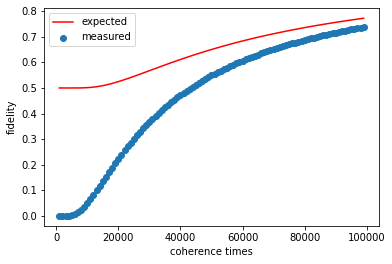

In [8]:
plt.figure()
plt.scatter(xdata, fidelity_probs, label="measured")
plt.plot(x, expected_fidelity_probs, "r-", label="expected")
plt.plot
plt.xlabel(xstring)
plt.ylabel("fidelity")
plt.legend()
plt.show()